In [2]:
!pip install torch torchvision pandas numpy scikit-learn matplotlib pillow


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
import matplotlib.pyplot as plt
import time
import os

class CenterNet(nn.Module):
    def __init__(self, num_classes):
        super(CenterNet, self).__init__()
        self.num_classes = num_classes
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512)
        )
        
        self.fc = None
        self._initialize_fc_layer()

    def _initialize_fc_layer(self):
        dummy_input = torch.zeros(1, 3, 256, 256)
        with torch.no_grad():
            dummy_output = self.backbone(dummy_input)
            num_features = dummy_output.numel() // dummy_output.size(0)
            self.fc = nn.Sequential(
                nn.Linear(num_features, 1024),
                nn.ReLU(inplace=True),
                nn.Linear(1024, self.num_classes)
            )
    
    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class PCBComponentDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        labels = self.annotations.iloc[idx, 1:].values.astype('float')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(labels)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

def load_class_names(csv_file):
    df = pd.read_csv(csv_file)
    class_names = df.columns[1:].tolist()
    return class_names

class_names = load_class_names('./data/train/_classes.csv')

train_dataset = PCBComponentDataset(
    csv_file='./data/train/_classes.csv',
    root_dir='./data/train',
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = PCBComponentDataset(
    csv_file='./data/valid/_classes.csv',
    root_dir='./data/valid',
    transform=transform
)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

test_dataset = PCBComponentDataset(
    csv_file='./data/test/_classes.csv',
    root_dir='./data/test',
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [4]:
model = CenterNet(num_classes=16)  # Adjust num_classes based on your dataset
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10 == 9:
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 10:.3f}")
            running_loss = 0.0

print("Finished Training")

[1, 10] loss: 0.830
[1, 20] loss: 0.582
[1, 30] loss: 0.481
[2, 10] loss: 0.433
[2, 20] loss: 0.420
[2, 30] loss: 0.362
[3, 10] loss: 0.354
[3, 20] loss: 0.328
[3, 30] loss: 0.304
[4, 10] loss: 0.273
[4, 20] loss: 0.268
[4, 30] loss: 0.302
[5, 10] loss: 0.174
[5, 20] loss: 0.200
[5, 30] loss: 0.218
[6, 10] loss: 0.119
[6, 20] loss: 0.147
[6, 30] loss: 0.134
[7, 10] loss: 0.115
[7, 20] loss: 0.103
[7, 30] loss: 0.088
[8, 10] loss: 0.072
[8, 20] loss: 0.061
[8, 30] loss: 0.063
[9, 10] loss: 0.049
[9, 20] loss: 0.034
[9, 30] loss: 0.043
[10, 10] loss: 0.029
[10, 20] loss: 0.024
[10, 30] loss: 0.028
Finished Training


In [5]:
def calculate_iou(preds, labels):
    intersection = np.logical_and(labels, preds)
    union = np.logical_or(labels, preds)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0
    return iou


In [6]:

def evaluate_model(loader, model, dataset_name="Dataset"):
    model.eval()
    all_labels = []
    all_preds = []
    inference_times = []

    with torch.no_grad():
        for inputs, labels in loader:
            start_time = time.time()
            outputs = model(inputs)
            end_time = time.time()

            preds = (outputs > 0.5).float()
            inference_times.append(end_time - start_time)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    precision = precision_score(all_labels, all_preds, average='micro')
    recall = recall_score(all_labels, all_preds, average='micro')
    f1 = f1_score(all_labels, all_preds, average='micro')
    ap = average_precision_score(all_labels, all_preds, average='micro')
    iou = calculate_iou(all_preds, all_labels)

    mean_inference_time = np.mean(inference_times)
    fps = 1.0 / mean_inference_time

    print(f"Metrics for {dataset_name}:")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"Average Precision (AP): {ap:.3f}")
    print(f"Mean Average Precision (mAP): {ap:.3f}")  # Using AP as mAP for simplicity
    print(f"IoU: {iou:.3f}")
    print(f"Inference Time: {mean_inference_time:.3f} seconds")
    print(f"FPS: {fps:.3f}\n")

    return precision, recall, f1, ap, iou, mean_inference_time, fps

val_metrics = evaluate_model(val_loader, model, dataset_name="Validation Dataset")
test_metrics = evaluate_model(test_loader, model, dataset_name="Test Dataset")

Metrics for Validation Dataset:
Precision: 0.671
Recall: 0.326
F1 Score: 0.439
Average Precision (AP): 0.421
Mean Average Precision (mAP): 0.421
IoU: 0.281
Inference Time: 0.144 seconds
FPS: 6.949

Metrics for Test Dataset:
Precision: 0.705
Recall: 0.389
F1 Score: 0.502
Average Precision (AP): 0.460
Mean Average Precision (mAP): 0.460
IoU: 0.335
Inference Time: 0.118 seconds
FPS: 8.509



In [7]:
torch.save(model.state_dict(), 'centernet_model1.pth')
print("Model saved as 'centernet_model1.pth'")

Model saved as 'centernet_model1.pth'


In [8]:
import torch
import pandas as pd
from tqdm import tqdm

# Example class names
class_names = [
    "IC", "LED", "battery", "buzzer", "capacitor", "clock", "connector",
    "diode", "display", "fuse", "inductor", "potentiometer", "relay",
    "resistor", "switch", "transistor"
]

# Initialize an empty list to collect results
results = []

# Function to process each batch and extract results
def process_batch(batch_results):
    return batch_results.numpy()  # Convert to numpy array directly

# Function to count detections for each class
def count_detections(scores, threshold=0.5):
    counts = {class_name: 0 for class_name in class_names}
    for score in scores:
        if score > threshold:  # Apply a threshold to consider a detection
            class_idx = int(score.argmax())  # Get the index of the highest score
            counts[class_names[class_idx]] += 1
    return counts

# Assume `test_loader` is your DataLoader for the test dataset
for images, targets in tqdm(test_loader, desc="Processing Batches"):
    # Assuming model inference or similar operation returns the results
    with torch.no_grad():
        outputs = model(images)  # Replace with actual model inference
        
        if isinstance(outputs, torch.Tensor):
            batch_results = outputs
        elif isinstance(outputs, dict) and 'scores' in outputs:
            batch_results = outputs['scores']
        else:
            raise ValueError("Unexpected output format from the model")
    
    # Check if `batch_results` has the right shape
    if batch_results.shape[0] != len(images):
        print(f"Warning: Batch results shape {batch_results.shape} does not match number of images in the batch {len(images)}")

    # Process the batch results
    batch_results_np = process_batch(batch_results)
    for image_idx, result in enumerate(batch_results_np):
        # Count detections for this image
        counts = count_detections(result)
        counts['image_idx'] = len(results)  # Add an index to track image order
        results.append(counts)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save DataFrame to CSV
results_df.to_csv("test_results1.csv", index=False)

print(f"Results shape: {results_df.shape}")
print(f"Test results saved to test_results1.csv")


Processing Batches: 100%|██████████| 3/3 [00:00<00:00,  4.37it/s]

Results shape: (39, 17)
Test results saved to test_results1.csv


In [33]:
#Pruning and Quantization

In [34]:
import torch.nn.utils.prune as prune

def prune_model(model, amount=0.2):
    # Apply pruning to the model
    for module in model.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name="weight", amount=amount)
    return model

# Apply pruning
pruned_model = prune_model(CenterNet(num_classes=16), amount=0.2)


In [35]:
import torch.quantization as quant

def prepare_and_convert_for_quantization(model):
    # Prepare the model for quantization
    model.train()  # Important for preparing quantization
    model = quant.prepare(model, inplace=False)
    # Run a calibration pass on a sample batch
    for images, _ in train_loader:
        model(images)
        break
    model = quant.convert(model, inplace=False)
    return model

# Apply quantization
quantized_model = prepare_and_convert_for_quantization(CenterNet(num_classes=16))


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/ao/quantization/quantize.py:312: UserWarning: None of the submodule got qconfig applied. Make sure you passed correct configuration through `qconfig_dict` or by assigning the `.qconfig` attribute directly on submodules
  warnings.warn("None of the submodule got qconfig applied. Make sure you "


In [36]:
# Define a function to evaluate a model
def evaluate_model_with_metrics(loader, model, dataset_name="Dataset"):
    model.eval()
    all_labels = []
    all_preds = []
    inference_times = []

    with torch.no_grad():
        for inputs, labels in loader:
            start_time = time.time()
            outputs = model(inputs)
            end_time = time.time()

            preds = (outputs > 0.5).float()
            inference_times.append(end_time - start_time)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    precision = precision_score(all_labels, all_preds, average='micro')
    recall = recall_score(all_labels, all_preds, average='micro')
    f1 = f1_score(all_labels, all_preds, average='micro')
    ap = average_precision_score(all_labels, all_preds, average='micro')
    iou = calculate_iou(all_preds, all_labels)

    mean_inference_time = np.mean(inference_times)
    fps = 1.0 / mean_inference_time

    print(f"Metrics for {dataset_name}:")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"Average Precision (AP): {ap:.3f}")
    print(f"Mean Average Precision (mAP): {ap:.3f}")  # Using AP as mAP for simplicity
    print(f"IoU: {iou:.3f}")
    print(f"Inference Time: {mean_inference_time:.3f} seconds")
    print(f"FPS: {fps:.3f}\n")

    return precision, recall, f1, ap, iou, mean_inference_time, fps


In [37]:
# Evaluate raw model
print("Evaluating raw model...")
raw_val_metrics = evaluate_model_with_metrics(val_loader, model, dataset_name="Validation Dataset")
raw_test_metrics = evaluate_model_with_metrics(test_loader, model, dataset_name="Test Dataset")

# Evaluate pruned model
print("Evaluating pruned model...")
pruned_val_metrics = evaluate_model_with_metrics(val_loader, pruned_model, dataset_name="Validation Dataset")
pruned_test_metrics = evaluate_model_with_metrics(test_loader, pruned_model, dataset_name="Test Dataset")

# Evaluate quantized model
print("Evaluating quantized model...")
quantized_val_metrics = evaluate_model_with_metrics(val_loader, quantized_model, dataset_name="Validation Dataset")
quantized_test_metrics = evaluate_model_with_metrics(test_loader, quantized_model, dataset_name="Test Dataset")


Evaluating raw model...
Metrics for Validation Dataset:
Precision: 0.742
Recall: 0.458
F1 Score: 0.567
Average Precision (AP): 0.502
Mean Average Precision (mAP): 0.502
IoU: 0.395
Inference Time: 0.151 seconds
FPS: 6.634

Metrics for Test Dataset:
Precision: 0.651
Recall: 0.442
F1 Score: 0.527
Average Precision (AP): 0.458
Mean Average Precision (mAP): 0.458
IoU: 0.357
Inference Time: 0.131 seconds
FPS: 7.641

Evaluating pruned model...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for Validation Dataset:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Average Precision (AP): 0.300
Mean Average Precision (mAP): 0.300
IoU: 0.000
Inference Time: 0.144 seconds
FPS: 6.933



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for Test Dataset:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Average Precision (AP): 0.304
Mean Average Precision (mAP): 0.304
IoU: 0.000
Inference Time: 0.134 seconds
FPS: 7.485

Evaluating quantized model...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for Validation Dataset:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Average Precision (AP): 0.300
Mean Average Precision (mAP): 0.300
IoU: 0.000
Inference Time: 0.120 seconds
FPS: 8.325

Metrics for Test Dataset:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Average Precision (AP): 0.304
Mean Average Precision (mAP): 0.304
IoU: 0.000
Inference Time: 0.107 seconds
FPS: 9.370



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
def print_comparison_summary():
    print("Performance Comparison:")
    print("\nRaw Model:")
    print(f"Validation Metrics: {raw_val_metrics}")
    print(f"Test Metrics: {raw_test_metrics}")

    print("\nPruned Model:")
    print(f"Validation Metrics: {pruned_val_metrics}")
    print(f"Test Metrics: {pruned_test_metrics}")

    print("\nQuantized Model:")
    print(f"Validation Metrics: {quantized_val_metrics}")
    print(f"Test Metrics: {quantized_test_metrics}")

print_comparison_summary()


Performance Comparison:

Raw Model:
Validation Metrics: (0.7415730337078652, 0.4583333333333333, 0.5665236051502146, 0.5023876404494382, 0.39520958083832336, 0.15073740482330322, 6.634053446602825)
Test Metrics: (0.6511627906976745, 0.4421052631578947, 0.5266457680250783, 0.45775429181181937, 0.3574468085106383, 0.13086509704589844, 7.641456909241958)

Pruned Model:
Validation Metrics: (0.0, 0.0, 0.0, 0.3, 0.0, 0.14422857761383057, 6.933438688395597)
Test Metrics: (0.0, 0.0, 0.0, 0.30448717948717946, 0.0, 0.13360063234965006, 7.4849945124726)

Quantized Model:
Validation Metrics: (0.0, 0.0, 0.0, 0.3, 0.0, 0.1201242208480835, 8.32471580618751)
Test Metrics: (0.0, 0.0, 0.0, 0.30448717948717946, 0.0, 0.10672434171040852, 9.369933643755358)


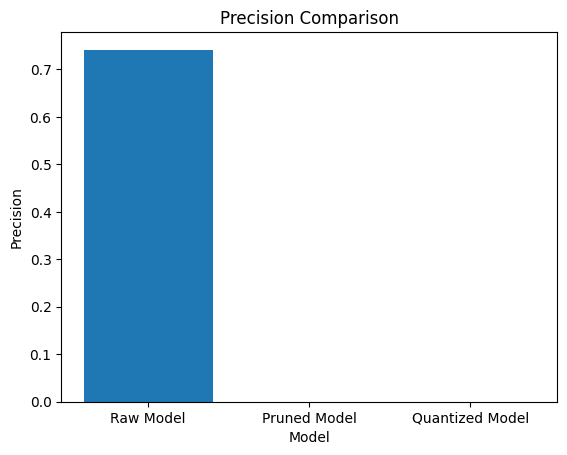

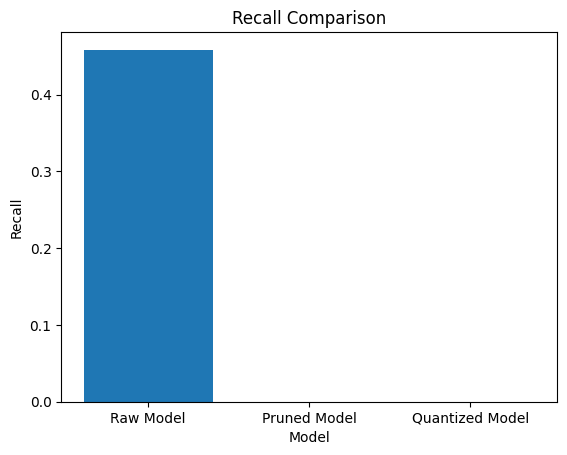

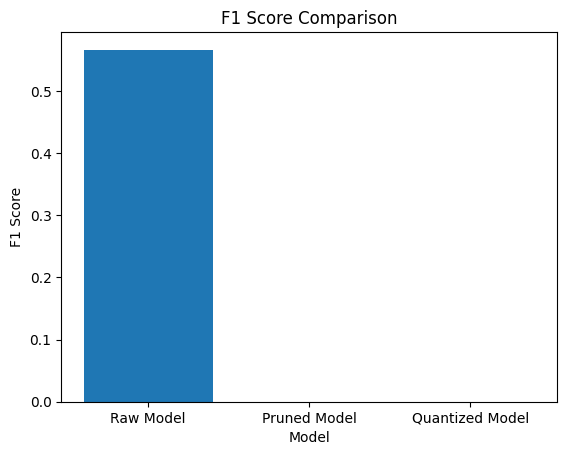

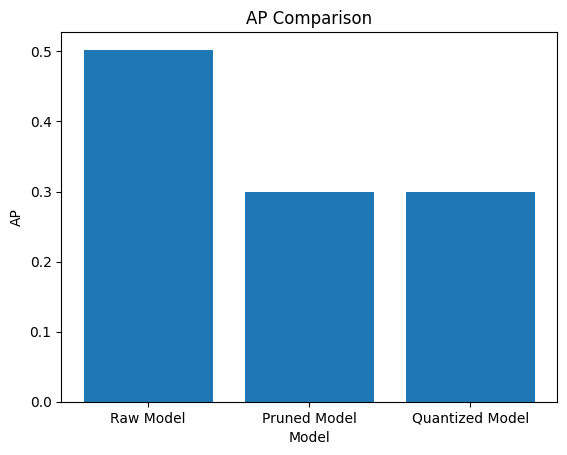

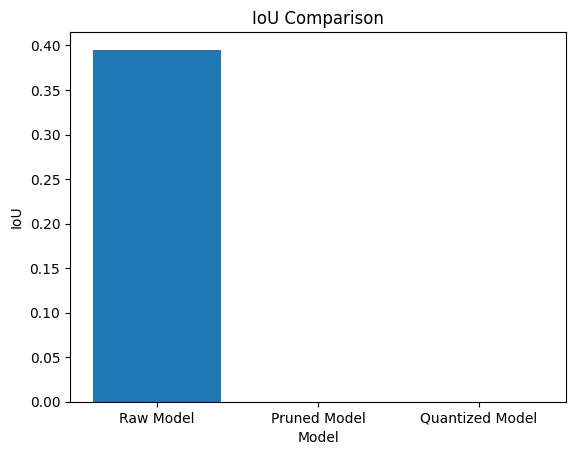

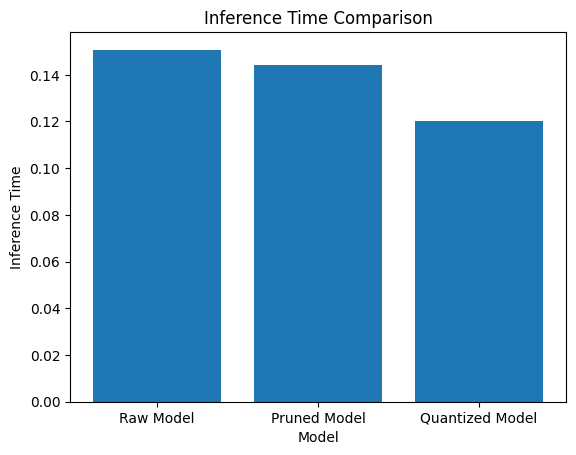

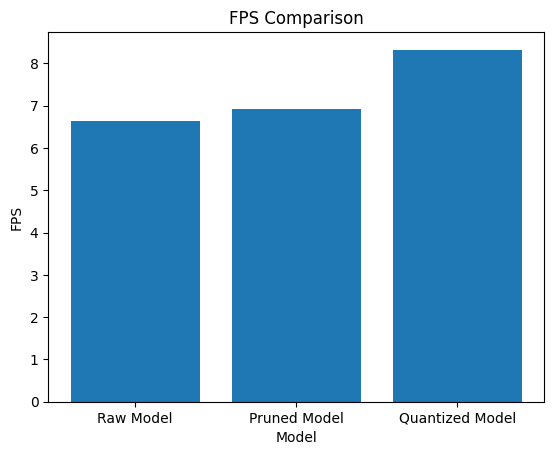

In [39]:
def plot_metrics(metrics_list, labels):
    metrics = ['Precision', 'Recall', 'F1 Score', 'AP', 'IoU', 'Inference Time', 'FPS']
    for i, metric in enumerate(metrics):
        plt.figure()
        plt.bar(labels, [metrics_list[j][i] for j in range(len(labels))])
        plt.title(f'{metric} Comparison')
        plt.xlabel('Model')
        plt.ylabel(metric)
        plt.show()

metrics_list = [raw_val_metrics, pruned_val_metrics, quantized_val_metrics]
labels = ['Raw Model', 'Pruned Model', 'Quantized Model']
plot_metrics(metrics_list, labels)


In [40]:
#The pruned model shows a significant drop in performance. This suggests that pruning may have overly reduced the model’s capacity or introduced issues that led to poor predictions. Despite similar inference time and FPS compared to the raw model, the quality of predictions has deteriorated drastically.

In [41]:
#The quantized model also shows a drop in performance similar to the pruned model. While it has improved inference time and FPS, its predictive quality is poor.